Alunos:
  - Ana Lívia Franco
  - João Guilherme Squinelato de Melo

Repositório: https://github.com/Squinelato/eEDB-001-2024-4

# Exercício 1

Os resultados obtidos contribuem para responder total ou parcialmente as demandas estabelecidas pelo Especialista do MC com o notebook do professor? Explique e justifique a sua resposta para cada questão do Especialista

1. **Análise de Tendências de Produtividade por Região e Cultura**

A nível de região não foi atendido, para tal, poderia ser feito um agrupamento dos dados por estados e por regiões, gerando gráficos de linha relacionando produção total ao longo dos anos.

2. **Avaliação do Impacto de Fatores Climáticos na Produção Agrícola**

Não foi atendido, pois necessitaria cruzar a base de dados de grãos com outros dados relativos a fatores ambientais.

3. **Análise de Desempenho por Cidade e Comparação Inter-Regional**

Foi atendido totalmente por meia da geração de gráficos de barras que demostravam a produção total por cidade.

4. **Identificação de Culturas Estratégicas para Exportação**

Não foi atendido, porém seria possível por meio de um gráfico de linha que representasse cada grão separadamente, e sua produtividade, em relação ao tempo.

5. **Monitoramento e Previsão de Riscos para a Safra Futuras**

Não foi atendido, pois necessitaria cruzar a base de dados de grãos com outros dados relativos a pragas e correlatos.

# Exercício 2: Demandas do Especialista do Ministério da Agricultura

Importando bibliotevas necessárias

In [2]:
from hashlib import sha1
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

## Préprocessamento de Dados sobre Grãos

### Lendo dados sobre área plantada

In [3]:
df_planted_area = pd.read_csv(
    filepath_or_buffer='data/raw/grains/planted_area.csv',
    sep=',',
    index_col=0,
)

Transformando tabela de tipo largo para longo

In [4]:
df_planted_area = pd.melt(
    frame=df_planted_area,
    id_vars=['Grain', 'Year'],
    var_name='city',
    value_name='planted_area'
)

Visualizando dados

In [5]:
df_planted_area.tail()

,Grain,Year,city,planted_area
2558975,Pea,2017,Brasília (DF),32.0
2558976,Barley,2018,Brasília (DF),100.0
2558977,Pea,2018,Brasília (DF),40.0
2558978,Barley,2019,Brasília (DF),100.0
2558979,Pea,2019,Brasília (DF),40.0


### Lendo dados sobre área colhida

In [6]:
df_harvested_area = pd.read_csv(
    filepath_or_buffer='data/raw/grains/harvested_area.csv',
    sep=',',
    index_col=0,
)

Transformando tabela de tipo largo para longo

In [7]:
df_harvested_area = pd.melt(
    frame=df_harvested_area,
    id_vars=['Grain', 'Year'],
    var_name='city',
    value_name='harvested_area'
)

Visualizando dados

In [8]:
df_harvested_area.tail()

,Grain,Year,city,harvested_area
2558975,Pea,2017,Brasília (DF),32.0
2558976,Barley,2018,Brasília (DF),100.0
2558977,Pea,2018,Brasília (DF),40.0
2558978,Barley,2019,Brasília (DF),70.0
2558979,Pea,2019,Brasília (DF),40.0


### Lendo dados sobre produtividade

In [9]:
df_yield = pd.read_csv(
    filepath_or_buffer='data/raw/grains/yield.csv',
    sep=',',
    index_col=0,
)

Transformando tabela de tipo largo para longo

In [10]:
df_yield = pd.melt(
    frame=df_yield,
    id_vars=['Grain', 'Year'],
    var_name='city',
    value_name='yield'
)

Visualizando dados

In [11]:
df_yield.tail()

,Grain,Year,city,yield
2558975,Pea,2017,Brasília (DF),7.0
2558976,Barley,2018,Brasília (DF),4.5
2558977,Pea,2018,Brasília (DF),7.0
2558978,Barley,2019,Brasília (DF),4.5
2558979,Pea,2019,Brasília (DF),7.0


### Lendo dados sobre produção

In [12]:
df_production = pd.read_csv(
    filepath_or_buffer='data/raw/grains/production.csv',
    sep=',',
    index_col=0
)

Transformando tabela de tipo largo para longo

In [13]:
df_production = pd.melt(
    frame=df_production,
    id_vars=['Grain', 'Year'],
    var_name='city',
    value_name='production'
)

Visualizando dados

In [14]:
df_production.tail()

,Grain,Year,city,production
2558975,Pea,2017,Brasília (DF),7.0
2558976,Barley,2018,Brasília (DF),4.5
2558977,Pea,2018,Brasília (DF),7.0
2558978,Barley,2019,Brasília (DF),4.5
2558979,Pea,2019,Brasília (DF),7.0


### Realizando cruzamento dos dados

Comparando se dados sobre produção e produtividade são diferentes

In [15]:
df_production['production'].equals(df_yield['yield'])

True

Neste dataset não são, logo podemos ficar com apenas um destes

Realizando mesca entre dados de plantio, colheita e produção

In [16]:
df_plantation = pd.merge(
    left=df_harvested_area,
    right=df_planted_area,
    how='inner',
    on=['Grain', 'Year', 'city']
)

df_plantation = pd.merge(
    left=df_plantation,
    right=df_production,
    how='left',
    on=['Grain', 'Year', 'city']
)

Extraindo unidade federativa do nome da cidade

In [17]:
df_plantation['state'] = df_plantation['city'].str.extract(r'\((\w{2})\)')

Removendo informação de unidade federativa da coluna de cidade e tratando nome de cidades

In [18]:
df_plantation['city'] = df_plantation['city'].str.replace(r'\(\w{2}\)', '', regex=True)
df_plantation['city'] = df_plantation['city'].str.strip()
df_plantation['city'] = df_plantation['city'].map(lambda city: unidecode(city.lower()))

Criando coluna com as regiões do brazil

In [19]:
brazil_regions = {
    'North': ['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO'],
    'Northeast': ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'],
    'Midwest': ['MT', 'MS', 'GO', 'DF'],
    'Southeast': ['MG', 'ES', 'RJ', 'SP'],
    'South': ['PR', 'SC', 'RS']
}

state_to_region = {state: region for region, states in brazil_regions.items() for state in states}

df_plantation['region'] = df_plantation['state'].map(state_to_region)

Criando chave artificial

In [20]:
df_plantation['artificial_key'] = (
    df_plantation['state']
    + df_plantation['city']
    + df_plantation['Grain']
    + df_plantation['Year'].astype(str)
).map(lambda x: sha1(x.encode('utf-8')).hexdigest())

Alterando nome de todas as colunas para _lower case_

In [21]:
df_plantation.columns = df_plantation.columns.map(lambda column: column.lower())

Alterando tipos das colunas

In [22]:
df_plantation = df_plantation.astype({
    'artificial_key': str,
    'region': str,
    'state': str,
    'city': str,
    'grain': str,
    'year': pd.UInt16Dtype(),
    'planted_area': pd.UInt64Dtype(),
    'harvested_area': pd.UInt64Dtype(),
    'production': pd.Float64Dtype(),
})

Alterando ordem das colunas

In [23]:
df_plantation = df_plantation.loc[:, ['artificial_key', 'region', 'state', 'city', 'grain', 'year', 'planted_area', 'harvested_area', 'production']]

Configurando novo índice para tabela

In [24]:
df_plantation.set_index('artificial_key', inplace=True)

Visualizando dados

In [25]:
df_plantation.tail()

,region,state,city,grain,year,planted_area,harvested_area,production
artificial_key,,,,,,,,
625f6e76440b34e39c5fc6e8b6a8bcab1ca5f04e,Midwest,DF,brasilia,Pea,2017,32,32,7.0
2e35bf97dc0e2b4e1bd59bbec0fde362625d5a3d,Midwest,DF,brasilia,Barley,2018,100,100,4.5
3cc26d41fe231b39cc768c4717f3abfdc7484fa2,Midwest,DF,brasilia,Pea,2018,40,40,7.0
da8a4979d4aaf9ed01dbf5b28e086f86d25aaab1,Midwest,DF,brasilia,Barley,2019,100,70,4.5
dee534fccb86bd1e04892bf1104189e932caed33,Midwest,DF,brasilia,Pea,2019,40,40,7.0


Salvando dados em formato .parquet particioando por ano

In [26]:
df_plantation.to_parquet(
    path='data/trusted/grains/plantation',
    engine='pyarrow',
    index=True,
    compression='snappy',
    partition_cols=['year']
)

## Identificação de Culturas Estratégicas para Exportação

Objetivo: Determinar quais culturas apresentam maior potencial para exportação com base em produtividade e estabilidade de produção ao longo dos anos.

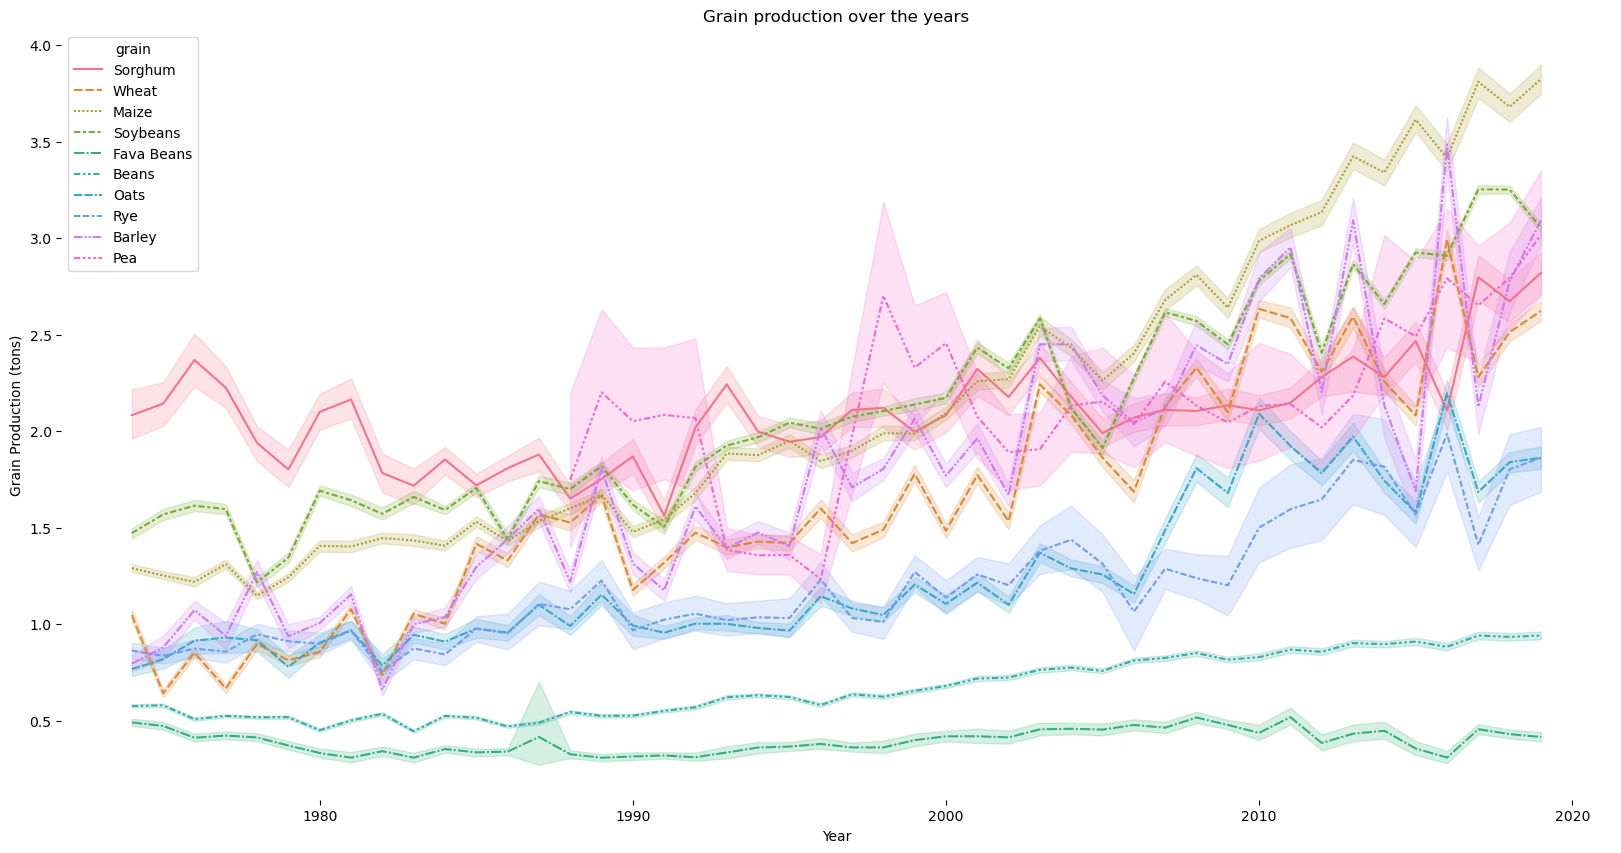

In [70]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(
    df_plantation,
    y='production',
    x='year',
    hue='grain',
    style='grain',
    palette='husl'
)

plt.xlabel('Year')
plt.ylabel('Grain Production (tons)')
plt.title('Grain production over the years')

sns.move_legend(ax, "best")
sns.despine(left=True, bottom=True)

**Resposta ao analista**: A produção de milho parece promissora e vem crescendo constantemente ao longo dos anos, além de oscilar pouco.

## Análise de Tendências de Produtividade por Região e Cultura

Objetivo: Avaliar a evolução da produtividade das principais culturas agrícolas (como soja, milho, café, entre outras) nas diferentes regiões do Brasil (Nordeste, Sudeste, Centro-Oeste, etc.) ao longo dos anos.

In [37]:
df_plantation_per_region = df_plantation.groupby(by=['region', 'year'])

df_plantation_per_region_sum = df_plantation_per_region[['production']].sum()
df_plantation_per_region_sum.reset_index(inplace=True)

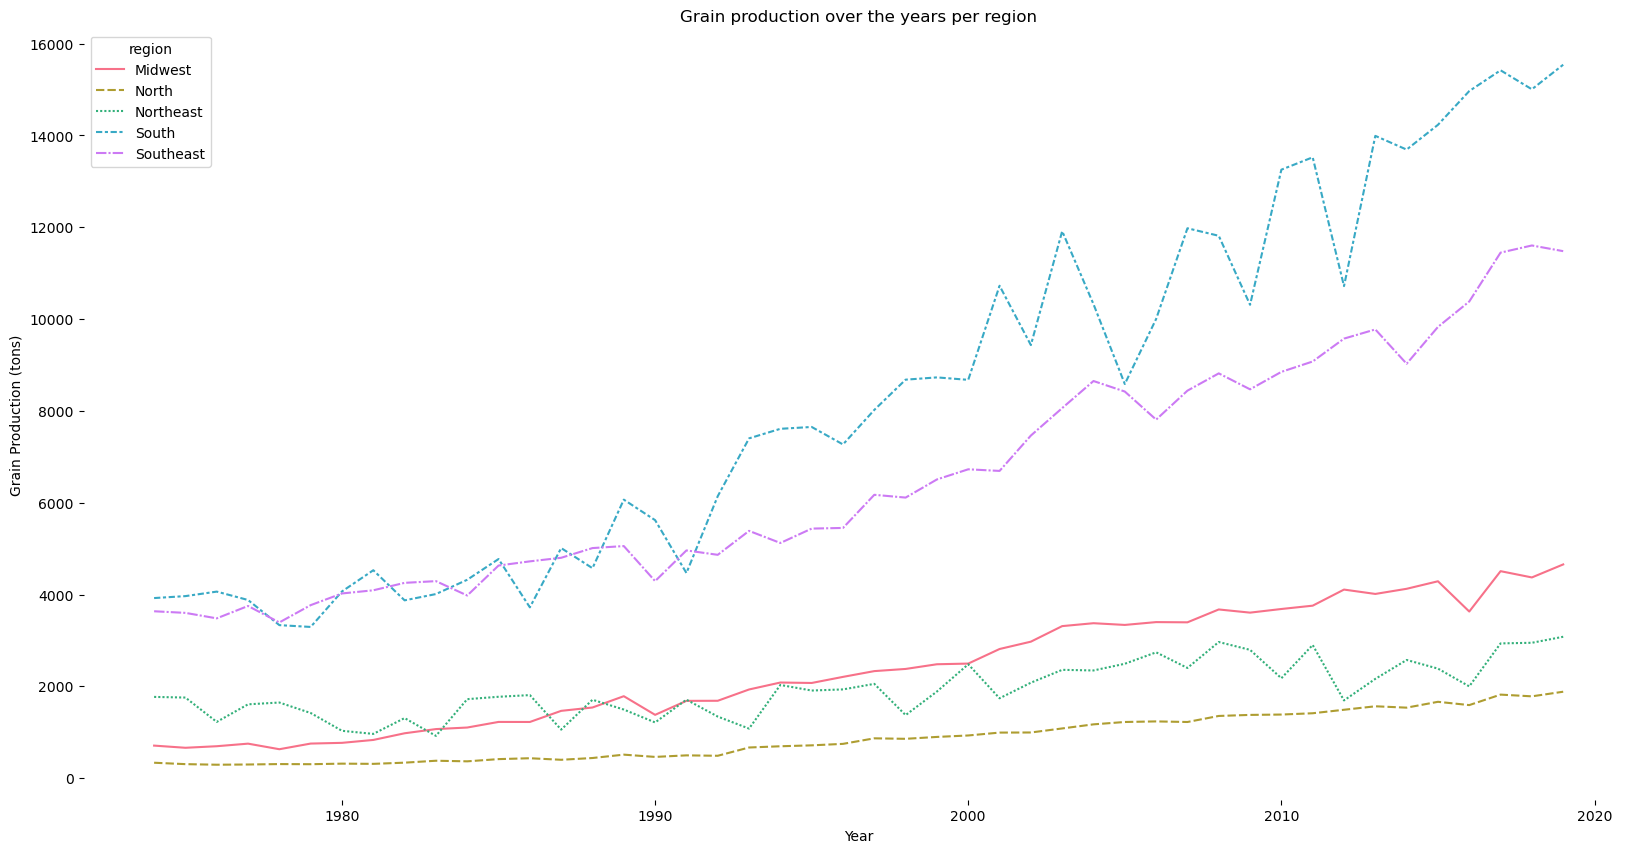

In [71]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(
    df_plantation_per_region_sum,
    y='production',
    x='year',
    hue='region',
    style='region',
    palette='husl'
)

plt.xlabel('Year')
plt.ylabel('Grain Production (tons)')
plt.title('Grain production over the years per region')

sns.move_legend(ax, "best")
sns.despine(left=True, bottom=True)

**Resposta ao analista**: A produção de grãos se destaca nas regiões sudeste e sul do pais, em que a partir de meados dos anos 90, o sul vem superando o sudeste consistentemente.

## Avaliação do Impacto de Fatores Climáticos na Produção Agrícola

### Dados metereológicos

Mapeando o caminho de todos os arquivos csv com dados metereológicos

In [40]:
folder_path = './data/raw/environmental'
csv_files = list(map(
    lambda file: f'{folder_path}/{file}',
    os.listdir(folder_path)
))

Criando função para ler metadados sobre a estação meteorológica

In [41]:
def extract_station_info(file_path: str, number_of_lines: int = 9):

    metadata = {}

    with open(file_path) as file:
        
        line_number = 1
        while line_number < 10:
            line = file.readline().strip()
            key, value = line.split(':')
            metadata[key.strip()] = value.strip()
            line_number += 1
    
    return metadata

Lendos todos os arquivos CSV

In [42]:
df_station = pd.DataFrame()
df_meteorology = pd.DataFrame()

for csv_file in csv_files:

    station_metadata = extract_station_info(csv_file)
    df_station_data = pd.DataFrame([station_metadata])
    df_station = pd.concat([df_station, df_station_data])

    df_meteorology_data = pd.read_csv(
        filepath_or_buffer=csv_file,
        sep=';',
        skiprows=10, # ignorar linhas com metadados
        index_col=False,
        usecols=range(7), # coletar apenas as 7 primeiras colunas do CSV,
        decimal=',',
        parse_dates=[0], # convertendo primeira coluna para tipo date
        dtype={ 1: pd.UInt16Dtype() } # convertendo segunda coluna para int
    )

    df_meteorology_data['station_code'] = station_metadata['Codigo Estacao']
    df_meteorology = pd.concat([df_meteorology, df_meteorology_data])

In [43]:
df_station[['city', 'sub_region']] = df_station['Nome'].str.split(
    pat='-',
    n=1,
    expand=True
)

Corrigindo algumas exceções

In [ ]:
paranoa_index = df_station['Nome'] == 'PARANOA (COOPA-DF)'
df_station['city'][paranoa_index] = 'PARANOA'
df_station['sub_region'][paranoa_index] = None

guarda_mor_index = df_station['Nome'] == 'GUARDA-MOR'
df_station['city'][guarda_mor_index] = 'GUARDA-MOR'
df_station['sub_region'][guarda_mor_index] = None

Tratando nomes de cidades e regiões

In [45]:
df_station['city'] = df_station['city'].map(lambda city: unidecode(city.lower()))
df_station['sub_region'] = df_station['sub_region'].map(lambda sub_region: unidecode(sub_region.lower()) if sub_region else None)

In [46]:
df_station.rename(
    inplace=True,
    columns={
        'Codigo Estacao': 'station_code',
        'Latitude': 'latitude',
        'Longitude': 'longitude',
        'Altitude': 'altitude',
        'Situacao': 'operational_condition',
        'Data Inicial': 'initial_date',
        'Data Final': 'final_date',
        'Periodicidade da Medicao': 'measurement_frequency',
    }
)

In [47]:
df_station = df_station.astype({
    'station_code': str,
    'latitude': 'Float64',
    'longitude': 'Float64',
    'altitude': 'Float64',
    'initial_date': 'datetime64[ns]',
    'final_date': 'datetime64[ns]',
})

In [48]:
df_station.drop(columns=['Nome'], inplace=True)

In [49]:
df_station.tail()

,station_code,latitude,longitude,altitude,operational_condition,initial_date,final_date,measurement_frequency,city,sub_region
0,A944,-14.828889,-56.441944,195.0,Operante,2019-05-29,2019-12-31,Mensal,rosario oeste,None
0,B803,-24.570833,-52.800278,598.0,Operante,2016-08-03,2019-12-31,Mensal,campina da lagoa,None
0,B804,-25.371389,-52.400833,889.0,Operante,2016-08-06,2019-12-31,Mensal,laranjeiras do sul,None
0,B806,-25.322464,-49.157733,950.0,Operante,2016-05-31,2019-12-31,Mensal,colombo,None
0,F501,-19.98,-43.958611,1199.55,Operante,2013-12-26,2019-12-31,Mensal,belo horizonte,cercadinho


In [50]:
df_station.to_parquet(
    path='data/trusted/environmental/station.parquet.snappy',
    engine='pyarrow',
    index=True,
    compression='snappy',
)

In [51]:
df_meteorology.rename(
    inplace=True,
    columns={
        'Data Medicao': 'measurement_date',
        'NUMERO DE DIAS COM PRECIP. PLUV, MENSAL (AUT)(número)': 'number_of_rainy_days',
        'PRECIPITACAO TOTAL, MENSAL (AUT)(mm)': 'total_precipitation',
        'PRESSAO ATMOSFERICA, MEDIA MENSAL (AUT)(mB)': 'atmospheric_pressure',
        'TEMPERATURA MEDIA, MENSAL (AUT)(°C)': 'average_temperature',
        'VENTO, VELOCIDADE MAXIMA MENSAL (AUT)(m/s)': 'maximum_wind_speed',
        'VENTO, VELOCIDADE MEDIA MENSAL (AUT)(m/s)': 'average_wind_speed',
    }
)

Agrupando dados por estação metereológica e por ano

In [52]:
df_meteorology['year'] = df_meteorology['measurement_date'].dt.year

In [53]:
group = df_meteorology.groupby(by=['station_code', 'year'])

In [54]:
sum_aggregations = group[['number_of_rainy_days', 'total_precipitation']].sum()
mean_aggregations = group[['atmospheric_pressure', 'average_temperature', 'average_wind_speed']].mean()
max_aggregations = group[['maximum_wind_speed']].max()

In [55]:
df_annual_meteorology = sum_aggregations \
    .merge(mean_aggregations, left_index=True, right_index=True) \
    .merge(max_aggregations, left_index=True, right_index=True)

In [56]:
df_annual_meteorology.reset_index(inplace=True)

In [57]:
df_annual_meteorology.tail()

,station_code,year,number_of_rainy_days,total_precipitation,atmospheric_pressure,average_temperature,average_wind_speed,maximum_wind_speed
6686,F501,2015,115,1343.8,883.141667,20.316667,5.391667,16.2
6687,F501,2016,112,1492.2,883.033333,20.066667,5.241667,16.7
6688,F501,2017,92,1237.8,883.275000,19.366667,5.575000,17.5
6689,F501,2018,138,1683.2,882.816667,19.591667,5.125000,17.6
6690,F501,2019,105,1211.4,883.200000,20.341667,5.275000,17.1


In [58]:
df_annual_meteorology.to_parquet(
    path='data/trusted/environmental/meteorology.parquet.snappy',
    engine='pyarrow',
    index=False,
    compression='snappy',
)

### Cruzamento de dados

In [59]:
df_station_meteorology = df_station.merge(df_annual_meteorology, on='station_code', how='inner')

In [60]:
group_station_meteorology = df_station_meteorology.groupby(by=['city', 'year'])

sum_aggregations = group_station_meteorology[['number_of_rainy_days', 'total_precipitation']].sum()
mean_aggregations = group_station_meteorology[['atmospheric_pressure', 'average_temperature', 'average_wind_speed']].mean()
max_aggregations = group_station_meteorology[['maximum_wind_speed']].max()

In [61]:
df_station_meteorology_per_city = sum_aggregations \
    .merge(mean_aggregations, left_index=True, right_index=True) \
    .merge(max_aggregations, left_index=True, right_index=True)

In [62]:
df_station_meteorology_per_city.reset_index(inplace=True)

In [63]:
df_environment_impact = df_plantation.merge(
    df_station_meteorology_per_city,
    how='inner',
    on=['city', 'year'],
)

Removendo cidades que não tiveram plantação

In [64]:
zero_planted_search = df_environment_impact['planted_area'] == 0
zero_planted_search_indexes = df_environment_impact[zero_planted_search].index
df_environment_impact.drop(index=zero_planted_search_indexes, inplace=True)

Preenchendo dados de produção com 0 em condições onde não se colheu nada

In [65]:
nan_prod_search = (df_environment_impact['production'].isna()) & (df_environment_impact['harvested_area'] == 0)
df_environment_impact.loc[nan_prod_search, 'production'] = 0

In [66]:
df_environment_impact.tail()

,region,state,city,grain,year,planted_area,harvested_area,production,number_of_rainy_days,total_precipitation,atmospheric_pressure,average_temperature,average_wind_speed,maximum_wind_speed
66645,Midwest,DF,brasilia,Pea,2017,32,32,7.0,117,1291.8,887.691667,21.458333,2.391667,9.1
66646,Midwest,DF,brasilia,Barley,2018,100,100,4.5,131,1668.6,887.566667,21.241667,2.200000,7.1
66647,Midwest,DF,brasilia,Pea,2018,40,40,7.0,131,1668.6,887.566667,21.241667,2.200000,7.1
66648,Midwest,DF,brasilia,Barley,2019,100,70,4.5,120,1394.0,887.866667,21.958333,2.200000,7.3
66649,Midwest,DF,brasilia,Pea,2019,40,40,7.0,120,1394.0,887.866667,21.958333,2.200000,7.3


### Análise Exploratória

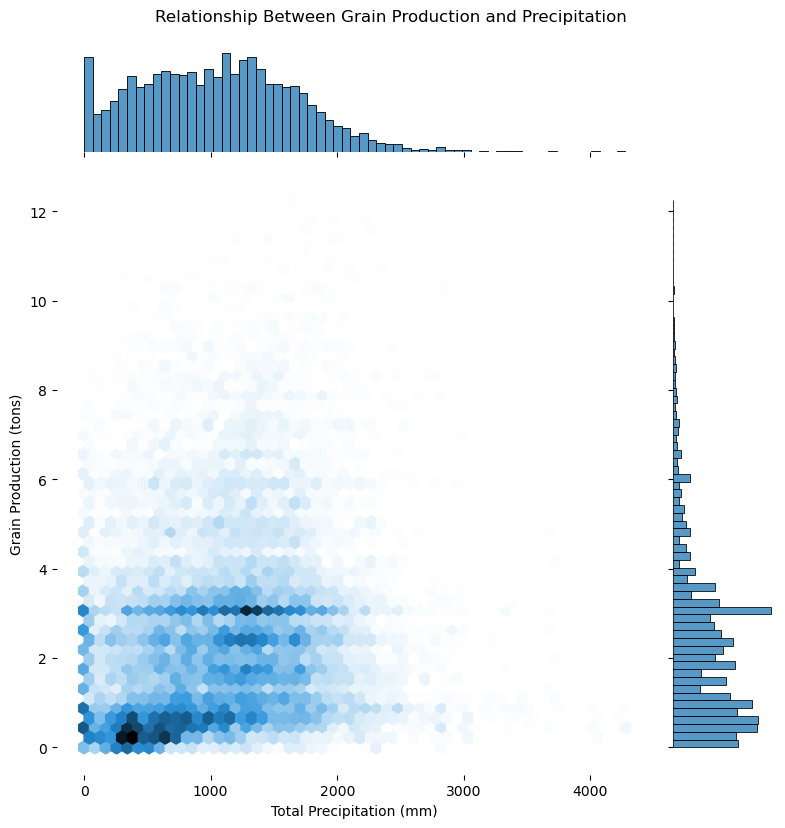

In [67]:
sns.jointplot(
   data=df_environment_impact,
   y='production',
   x='total_precipitation',
   kind='hex',
   height=8,
)

plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Grain Production (tons)')
plt.suptitle('Relationship Between Grain Production and Precipitation', y=1.03)

sns.despine(left=True, bottom=True)

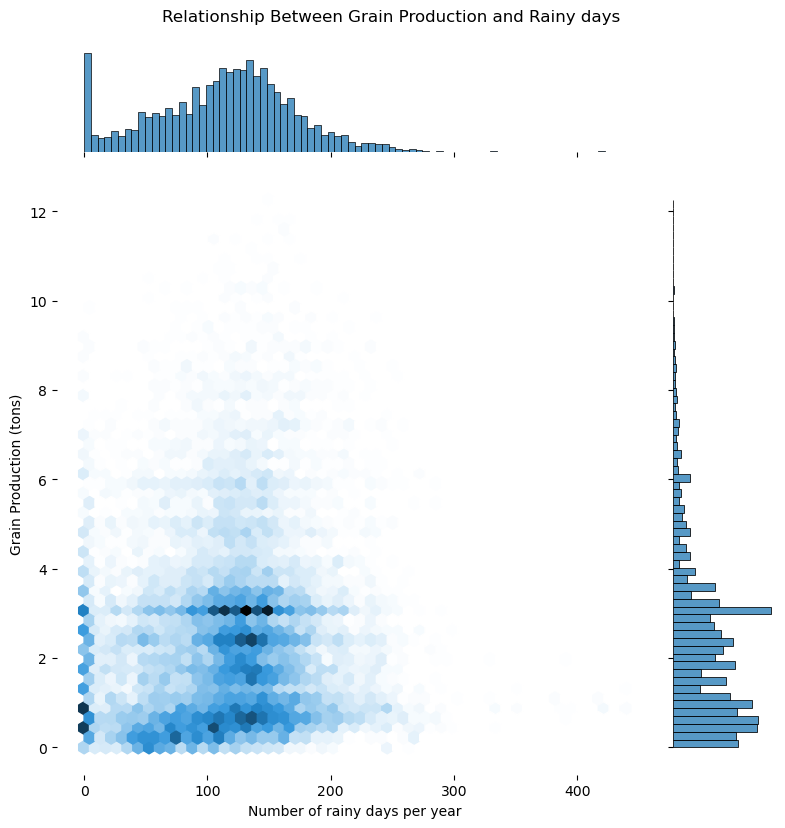

In [68]:
sns.jointplot(
   data=df_environment_impact,
   y='production',
   x='number_of_rainy_days',
   kind='hex',
   height=8,
)

plt.xlabel('Number of rainy days per year')
plt.ylabel('Grain Production (tons)')
plt.suptitle('Relationship Between Grain Production and Rainy days', y=1.03)

sns.despine(left=True, bottom=True)

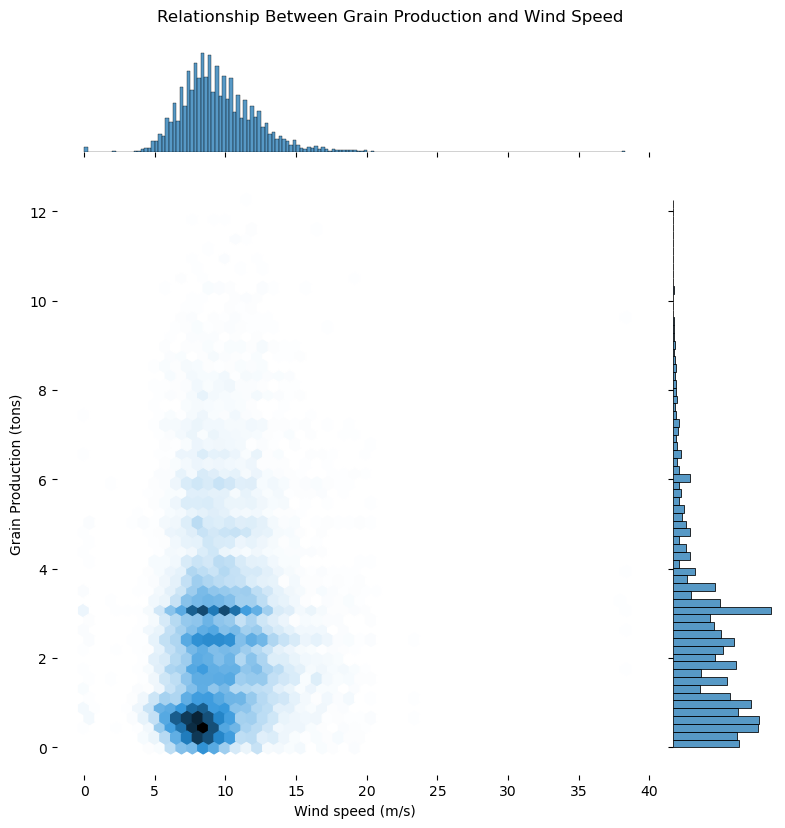

In [69]:
sns.jointplot(
   data=df_environment_impact,
   y='production',
   x='maximum_wind_speed',
   kind='hex',
   height=8,
)

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Grain Production (tons)')
plt.suptitle('Relationship Between Grain Production and Wind Speed', y=1.03)

sns.despine(left=True, bottom=True)

**Resposta ao analista**: Não foi observado correlação entre fatores ambientas e produção de grãos, o que levanta uma suspeita de que provavelmente variáveis foram desconsideradas. Por exemplo, não tem-se a informação de quando os grãos foram plantados e colhidos, isto é, dados sobre a safra. Por outro lado, inferir a safra de um grão pode tornar-se um trabalho arduo uma vez que cada região do brasil tem safras diferentes para um mesmo grão, além de que isto pode mudar ao longo dos anos. Além disso, não se tem dados de qual foi o aporte financeiro realizado nestas plantações, isto é, se trata de um pequeno agricultor familiar ou de um grande latifundiário? Estas perguntas precisariam ser respondidas com o auxílio de um especialista para que seja possível extrair maior valor destes dados.